<a href="https://colab.research.google.com/github/joshuajhchoi/ai2learn/blob/master/dcgan_with_MNIST_2021_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 
Acknowledgement: Portions of this page are reproduced from work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License.

# DCGAN with MNIST (TensorFlow)

* First install TensorFlow

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
# We install imageio to make GIFs
!pip install imageio

In [ ]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used
import glob
# imageio is a Python library that provides an easy interface to read and write a wide range of image data,
import imageio

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# PIL is Python Imaging Library which is a free and open-source additional library for the Python programming language 
# that adds support for opening, manipulating, and saving many different image file formats.
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
import random
%load_ext tensorboard
from IPython import display

%matplotlib inline

### Loading and preparing the dataset
We will use the MNIST dataset to train the Generator and Discriminator. 

The Generator will generate numbers that resemble handwritten numeric data. 

In [ ]:
# mnist dataset is in sample data 
from keras.datasets.mnist import load_data

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [ ]:
BUFFER_SIZE = 120000
BATCH_SIZE = 256


In [ ]:
# Create batches of data and shuffle them.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creating the model
Generator and Discriminator are defined using [Keras Sequential API] 


In [ ]:
# Let's make genrator model function

def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', 
                                     use_bias=False, activation='tanh')) 
    assert model.output_shape == (None, 28, 28, 1) 

    return model

Let's create an image using a generator that hasn't been trained yet.

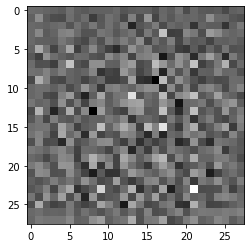

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator
Discriminator is an image classifier based on Convolutional Neural Network (CNN).

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
 
    model.add(layers.Dense(1))

    return model

   

Like Generator, it uses a Discriminator (which has not yet been trained) to determine if the generated image is real or fake. 

The model is trained to output positive values for real images and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00076101]], shape=(1, 1), dtype=float32)


## Loss function and optimizer
Define the loss function and optimizer for both models.

In [ ]:
# This method returns a helper function to compute the cross entropy loss. (for Binary Classification)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss Function

This method quantifies how well the Discriminator determines real images from fake images. 

Compare the Discriminator's prediction of the real image with a matrix of 1s, and the Discriminator's prediction of the fake (generated) image with a matrix of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss function

Generator's loss function quantifies how well the Discriminator is tricked. 

Intuitively, if Generator is running smoothly, Discriminator will classify fake images as real (or 1). Here we will compare the Discriminator's decision on the generated image to a matrix of ones.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Use Adam as the Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoint
This notebook shows you how to save and restore models that can be useful in cases where long-running training is disrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Experiment utils (RUN ME!)

In [ ]:
# Define the training loop

EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Model Traning

In [ ]:
# Create and save images

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

# Instantly create images for GIF.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


# It saves the model every 15 epoch passes
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    

 # print the report on how much time it takes for each epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the last epoch is over.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


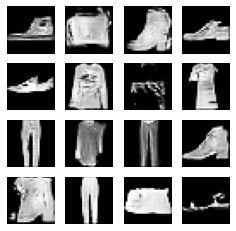

CPU times: user 43min 54s, sys: 5min 49s, total: 49min 44s
Wall time: 1h 44min 40s


In [ ]:
# # Model training
%%time
train(train_dataset, EPOCHS)

In [ ]:
# Restore the last checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Create GIF
# Displays a single image using epoch numbers.

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

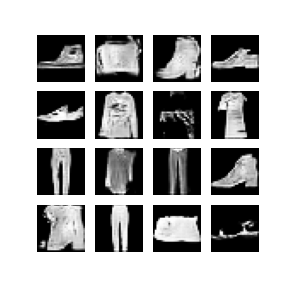

In [ ]:
display_image(EPOCHS)

In [ ]:
# Create a GIF animation using images saved during training with imageio.

anim_file = 'dcganwithfashionmnist.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
# If you are working at Colab, you can download the animation from the code below:

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>